# Basic example for bssunfold package

In [1]:
# %pip install bssunfold pandas numpy matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from bssunfold import Detector

## Load the response functions file for the BSS
- first column: Energy in MeV
- other columns: detector responses for the set of moderator spheres

In [3]:
# response functions default GSF
from bssunfold import RF_GSF
df = pd.DataFrame.from_dict(RF_GSF, orient='columns')
Detector_GSF = Detector(df)

In [4]:
# reference spectrum ISO Cf-252.
reference_spectrum = {
    "E_MeV": [
        1e-09,
        1.5848931924611136e-09,
        2.5118864315095803e-09,
        3.981071705534973e-09,
        6.309573444801934e-09,
        1e-08,
        1.5848931924611143e-08,
        2.511886431509581e-08,
        3.9810717055349736e-08,
        6.309573444801934e-08,
        1.0000000000000001e-07,
        1.5848931924611143e-07,
        2.5118864315095823e-07,
        3.9810717055349735e-07,
        6.309573444801937e-07,
        1.0000000000000002e-06,
        1.584893192461114e-06,
        2.5118864315095823e-06,
        3.981071705534973e-06,
        6.309573444801937e-06,
        1e-05,
        1.584893192461114e-05,
        2.5118864315095822e-05,
        3.9810717055349776e-05,
        6.309573444801943e-05,
        0.0001,
        0.00015848931924611142,
        0.0002511886431509582,
        0.0003981071705534978,
        0.0006309573444801943,
        0.001,
        0.0015848931924611143,
        0.0025118864315095825,
        0.003981071705534978,
        0.006309573444801942,
        0.01,
        0.01584893192461114,
        0.025118864315095826,
        0.039810717055349776,
        0.06309573444801943,
        0.1,
        0.15848931924611173,
        0.25118864315095824,
        0.3981071705534969,
        0.6309573444801944,
        1.0,
        1.5848931924611174,
        2.5118864315095824,
        3.9810717055349856,
        6.309573444801943,
        10.0,
        15.848931924611176,
        25.118864315095824,
        39.810717055349855,
        63.09573444801943,
        100.0,
        158.48931924611173,
        251.18864315095823,
        398.1071705534986,
        630.9573444801944,
    ],
    "Phi": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0002193244132568562,
        0.000922,
        0.0017977302145640818,
        0.0033934229230273556,
        0.00638236969883396,
        0.01212580290671056,
        0.0237,
        0.04468185467401807,
        0.0822779218679577,
        0.1450462719353082,
        0.2413649401952857,
        0.359,
        0.45221093414611185,
        0.4338707690763234,
        0.2708850368693928,
        0.0856762250762,
        0.00427,
        0.0004258199483775139,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ],
}

In [5]:
# effective readings of the GSF BSS for the reference spectrum [reading per second]
readings = {
    "0in": 0.00037,
    "2in": 0.00999,
    "3in": 0.05366,
    "5in": 0.18417,
    "6in": 0.21968,
    "8in": 0.22007,
    "10in": 0.17214,
    "12in": 0.12033,
    "15in": 0.06674,
    "18in": 0.03411,
}

## Unfold the spectrum
1) Tikhonov regularization solded with CVXPY, ECOS solver
2) Landweber iterative unfolding
3) CVXPY results are used as initial guess for Landweber unfolding

In [6]:
result_cvxpy = Detector_GSF.unfold_cvxpy(readings, regularization=1e-4)

results = {
    "CVXPY": result_cvxpy,
    "CVXPY[ECOS]": Detector_GSF.unfold_cvxpy(
        readings, regularization=1e-4, solver="ECOS"
    ),
    "Landweber": Detector_GSF.unfold_landweber(readings, max_iterations=3000),
    "CVXPY -> Landweber": Detector_GSF.unfold_landweber(
        readings, initial_spectrum=result_cvxpy["spectrum"], max_iterations=3000
    ),
}

Status: optimal
Objective value: 8.30923138966197e-05
Residual norm: 0.000000
Result saved with key: 20260119_115527_cvxpy
Status: optimal
Objective value: 8.308965699210048e-05
Residual norm: 0.000000
Result saved with key: 20260119_115527_cvxpy
Result saved with key: 20260119_115527_Landweber
Result saved with key: 20260119_115527_Landweber


# Unfolding with uncertainty

In [7]:
# Unfold spectrum with uncertainty calculation based on Monte-Carlo
n_montecarlo = 100  # number of random samples of readings with noise
noise_level = 0.01  # Gaussian noise for readings, 5%

# 1 CVXPY
result_cvxpy_unc = Detector_GSF.unfold_cvxpy(
    readings,
    regularization=1e-4,
    calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)
# 2 Landweber
result_landweber_unc = Detector_GSF.unfold_landweber(
    readings, calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)
# 3 CVXPY -> Landweber
result_cvxpy_landweber_unc = Detector_GSF.unfold_landweber(
    readings,
    initial_spectrum=result_cvxpy_unc["spectrum"],
    max_iterations=3000,
    calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)

Status: optimal
Objective value: 8.30923138966197e-05
Residual norm: 0.000000
Calculating uncertainty with Monte-Carlo...
Status: optimal
Objective value: 0.0015966090311812721
Status: optimal
Objective value: 0.00019748229527137754
Status: optimal
Objective value: 0.0005098298409557911
Status: optimal
Objective value: 0.0007910595075903856
Status: optimal
Objective value: 0.00018198645035877304
Status: optimal
Objective value: 0.0013823759806029434
Status: optimal
Objective value: 0.0005783818330814805
Status: optimal
Objective value: 0.0031013284875445525
Status: optimal
Objective value: 0.001622689253864074
Status: optimal
Objective value: 0.0009332211579077318
Status: optimal
Objective value: 0.0009073500078933386
Status: optimal
Objective value: 0.0011469291627972718
Status: optimal
Objective value: 0.0016396645124617199
Status: optimal
Objective value: 0.0002670472408371381
Status: optimal
Objective value: 0.0012968156672590644
Status: optimal
Objective value: 0.00213176041045306

In [8]:
result_cvxpy_landweber_unc

{'energy': array([1.00000000e-09, 1.58489319e-09, 2.51188643e-09, 3.98107171e-09,
        6.30957344e-09, 1.00000000e-08, 1.58489319e-08, 2.51188643e-08,
        3.98107171e-08, 6.30957344e-08, 1.00000000e-07, 1.58489319e-07,
        2.51188643e-07, 3.98107171e-07, 6.30957344e-07, 1.00000000e-06,
        1.58489319e-06, 2.51188643e-06, 3.98107171e-06, 6.30957344e-06,
        1.00000000e-05, 1.58489319e-05, 2.51188643e-05, 3.98107171e-05,
        6.30957344e-05, 1.00000000e-04, 1.58489319e-04, 2.51188643e-04,
        3.98107171e-04, 6.30957344e-04, 1.00000000e-03, 1.58489319e-03,
        2.51188643e-03, 3.98107171e-03, 6.30957344e-03, 1.00000000e-02,
        1.58489319e-02, 2.51188643e-02, 3.98107171e-02, 6.30957344e-02,
        1.00000000e-01, 1.58489319e-01, 2.51188643e-01, 3.98107171e-01,
        6.30957344e-01, 1.00000000e+00, 1.58489319e+00, 2.51188643e+00,
        3.98107171e+00, 6.30957344e+00, 1.00000000e+01, 1.58489319e+01,
        2.51188643e+01, 3.98107171e+01, 6.30957344e+01

# Plot spectra with uncertanity

- use of Landweber iterations to stabilize the solution from CVXPY

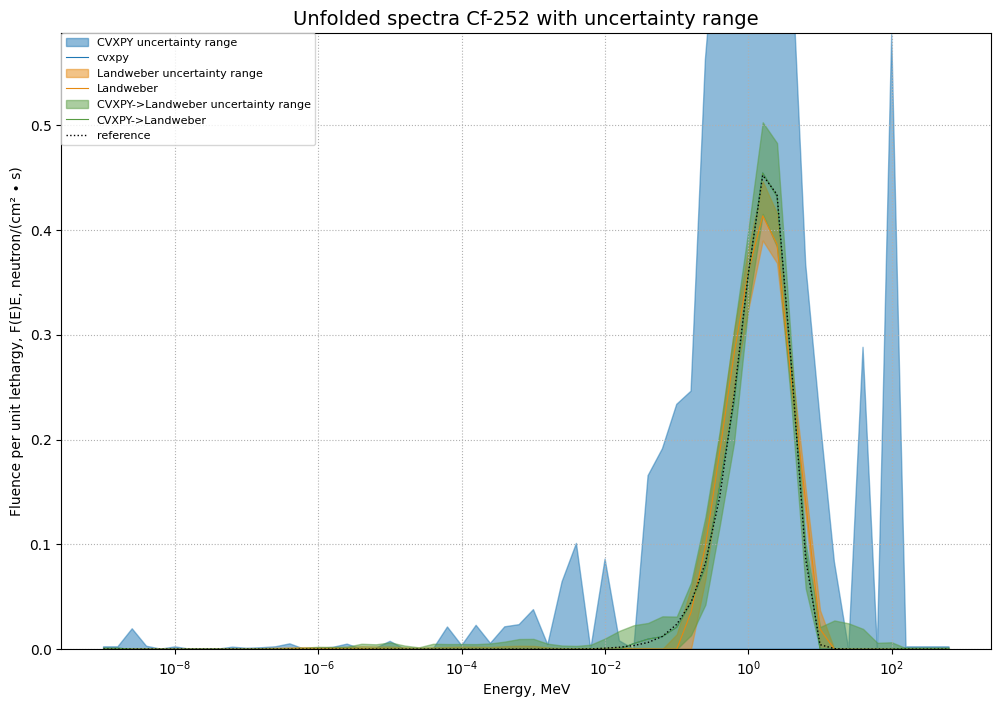

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
methods = list(results.keys())
all_labels = ["reference"] + methods

colors = ["black", "#1f77b4", "#e68910", "#589c43", "indianred"]
# Первый график (спектры)

ax.fill_between(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum_uncert_min"],
    result_cvxpy_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[1],
    label="CVXPY uncertainty range",
)

ax.plot(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum"],
    label="cvxpy",
    color=colors[1],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

ax.fill_between(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum_uncert_min"],
    result_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[2],
    label="Landweber uncertainty range",
)

ax.plot(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum"],
    label="Landweber",
    color=colors[2],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

# CVXPY -> Landweber
ax.fill_between(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum_uncert_min"],
    result_cvxpy_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[3],
    label="CVXPY->Landweber uncertainty range",
)

ax.plot(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum"],
    label="CVXPY->Landweber",
    color=colors[3],
    ls="-",
    linewidth=0.8,
    alpha=1,
)



ax.plot(
    reference_spectrum["E_MeV"],
    reference_spectrum["Phi"],
    label="reference",
    linewidth=1,
    linestyle=":",
    color=colors[0],
)

ax.set_xlabel("Energy, MeV")
ax.set_ylabel("Fluence per unit lethargy, F(E)E, neutron/(cm² ∙ s)")
ax.set_xscale("log")
ax.set_ylim(0,np.max(reference_spectrum["Phi"])*1.3)
ax.legend(loc="upper left", borderaxespad=0.0, fontsize=8)
ax.grid(True, which="both", ls=":")
ax.set_title(f"Unfolded spectra Cf-252 with uncertainty range", fontsize=14)
plt.show()

# Barplot with uncertainty

ref mean error = 1.00%
cvxpy mean error = 4.37%
landweber mean error = 4.93%
cvxpy_landweber mean error = 1.96%


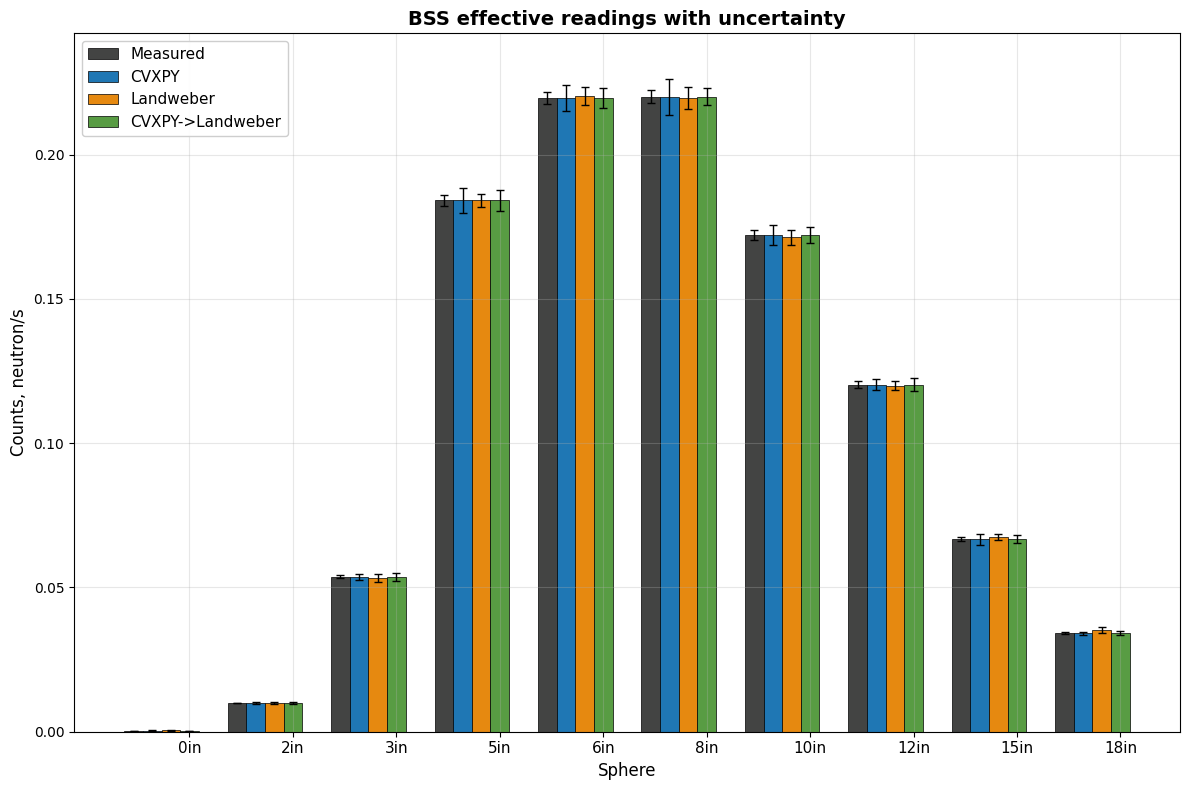

In [ ]:
def calculate_effective_readings_with_uncertainty(result_dict, readings, detector_matrix):
    """
    Универсальная функция для расчета эффективных показаний с погрешностью
    
    Параметры:
    - result_dict: словарь с результатами метода (должен содержать spectrum_uncert_all)
    - readings: исходные показания детектора
    - detector_matrix: матрица отклика детектора
    
    Возвращает:
    - uncert_min: минимальные эффективные показания
    - uncert_max: максимальные эффективные показания
    """
    if 'spectrum_uncert_all' in result_dict:
        # Для Landweber: используем спектры с неопределенностью
        eff_readings_unc = []
        for spectra in result_dict['spectrum_uncert_all']:
            eff_readings_unc.append(detector_matrix @ spectra)
        return np.min(eff_readings_unc, axis=0), np.max(eff_readings_unc, axis=0)
    else:
        # Если нет данных о неопределенности
        return None, None
    
    
# Подготовка данных
categories = list(readings.keys())
n_categories = len(categories)
ref_values = [readings[cat] for cat in categories]

# Словарь с результатами методов
methods_data = {
    'cvxpy': result_cvxpy_unc,
    'landweber': result_landweber_unc,
    'cvxpy_landweber': result_cvxpy_landweber_unc
}

# Рассчитываем неопределенности для всех методов
uncertainties = {}
for method_name, result in methods_data.items():
    uncert_min, uncert_max = calculate_effective_readings_with_uncertainty(
        result, readings, Detector_GSF.get_response_matrix(readings)
    )
    uncertainties[method_name] = {'uncert_min': uncert_min, 'uncert_max': uncert_max}
    
    
# Настройки для отображения
method_configs = {
    'ref': {
        'color': '#434443',
        'label': 'Measured'
    },
    'cvxpy': {
        'color': '#1f77b4', 
        'label': 'CVXPY'
    },
    'landweber': {
        'color': '#e68910',
        'label': 'Landweber'
    },
    'cvxpy_landweber': {
        'color': '#589c43',
        'label': 'CVXPY->Landweber'
    }
}

# Создаем основной словарь данных для графика
datasets = {}
datasets['ref'] = {
    **method_configs['ref'],
    'values': ref_values,
    'uncert_min': [ val - val* noise_level for key,val in readings.items()], # known noise during measurements - low bound
    'uncert_max': [ val + val* noise_level for key,val in readings.items()]  # known noise during measurements - upper bound
}

for method_name in methods_data.keys():
    datasets[method_name] = {
        **method_configs[method_name],
        'values': [methods_data[method_name]["effective_readings"][cat] for cat in categories],
        **uncertainties[method_name]
    }


# Включаем все методы
all_methods = ['ref', 'cvxpy', 'landweber', 'cvxpy_landweber']
n_all_methods = len(all_methods)

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.18
x = np.arange(n_categories)

# Смещения для всех методов
offsets_all = np.linspace(-bar_width*(n_all_methods-1)/2, bar_width*(n_all_methods-1)/2, n_all_methods)

# Построение столбцов для всех методов
for i, method in enumerate(all_methods):
    method_data = datasets[method]
    values = method_data['values']
    label = method_data['label']
    color = method_data['color']
    
    x_positions = x + offsets_all[i]
    
    # Определяем ошибки (только для методов с uncert_min/max)
    if method_data['uncert_min'] is not None and method_data['uncert_max'] is not None:
        # if lower bound < 0 then == 0. 
        yerr_lower =  [max(0, values[j] - method_data['uncert_min'][j]) for j in range(len(values))]
        yerr_upper =  [max(0, values[j] - method_data['uncert_min'][j]) for j in range(len(values))]
        yerr = [yerr_lower, yerr_upper]
        
        bars = ax.bar(x_positions, values, bar_width, 
                      label=label, color=color, edgecolor='black', linewidth=0.5)
        
        ax.errorbar(x_positions, values, yerr=yerr, fmt='none', 
                   color='black', capsize=3, linewidth=1, capthick=1)
        
        # calculate mean error for effective readings
        # combination cvxpy->landweber reduced the error
        print(method,f'mean error = {np.mean((np.array(yerr_lower)) / np.array(values)):.2%}')
    else:
        # Для ref просто строим столбцы без ошибок
        bars = ax.bar(x_positions, values, bar_width, 
                      label=label, color=color, edgecolor='black', linewidth=0.5)


plt.title('BSS effective readings with uncertainty', fontsize=14, fontweight='bold')
plt.xlabel('Sphere', fontsize=12)
plt.ylabel('Counts, neutron/s', fontsize=12)
plt.xticks(x_positions, categories, fontsize=11)
plt.ylim(0, max(ref_values) * 1.1)
plt.grid(True, alpha=0.3, zorder=0)

plt.legend(fontsize=11, loc='upper left', framealpha=0.95)
plt.tight_layout()
plt.show()